# Bayesian optimization

## Implement the SMBO optimizer. This Notebook Features:

 - Rastrigin function as objective function
 - SMBO using Guassian processes and Random Forest as surrogate with variable Hyperparameters
 - A Random search baseline (radius 1+1 EA search) with variable Hyperparameters
 - Methods to compare the different methods with each other
     - Graph with best find history
     - Table comparison
     - For 2D/3D, method to compare the location of the best points found by the methods
 



In [758]:
# general import
import math 
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
from matplotlib.pyplot import figure
import pandas as pd
from statistics import  stdev

In [759]:
# turn off warnings in jupyter
import warnings; warnings.simplefilter('ignore')

In [760]:
# rastrigin function class
def rastrigin(dims=2):
    def formula(hyperparameters):
        out = 10*dims 
        for x in range (dims):
            if hyperparameters[x] > 5.12 or hyperparameters[x] < -5.12:   #function is limited by 5.12
                print("X is out of boundary.")
                return math.inf
            out = out + hyperparameters[x]**2 - 10* math.cos(2*math.pi*hyperparameters[x])        
        return out
    return formula    

In [785]:
# 2D display
def display_function_2D(samples_n,X,Y):
    figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
    function = rastrigin(1)
    samples2DY = []
    samples2DX = []
    for x in range(samples_n):
        sampleX = random.uniform(-5.12,5.12)
        samples2DX.append(sampleX)
        samples2DY.append(function([sampleX]))
    plt.title("2D Rastrigin-Function")
    plt.scatter(samples2DX,samples2DY,color="lightgrey")
    for w in range(len(X)):
        plt.scatter(X[w],Y[w],marker= 'X')
    plt.legend(["Real Function,""Bayesian Optimization with Gaussian Process and 90% exploration",
            "Bayesian Optimization with Gaussian Process and 50% exploration",
            "Random Search with radius 0.1",
            "Random Search with radius 0.5",
            "Bayesian Optimization with Random Forest and 90% exploration",
            "Bayesian Optimization with Random Forest and 50% exploration"])

In [762]:
#3D display
def display_function_3D(samples,X,Y):
    function = rastrigin(2)
    samples3DY = []
    samples3DX = []
    samples3DZ = []
    for x in range(samples):
        sampleX = random.uniform(-5.12,5.12)
        samples3DX.append(sampleX)
        sampleZ = random.uniform(-5.12,5.12)
        samples3DZ.append(sampleZ)
        samples3DY.append(function([sampleX,sampleZ]))
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    plt.title("3D Rastrigin-Function")
    ax.plot_trisurf(samples3DX,samples3DZ,samples3DY, cmap=plt.cm.Greys)
    for x in range(len(X)):  
        ax.scatter([X[x][0],X[x][1]],[Y[x]],marker= 'X')

In [763]:
# general objective function. Here in order to fill different models
def objective_function(hyperparameters,params):   #insert test/train data here if existing
    
    # Machine learning model
    rf = rastrigin(params)    # insert hyperparameters here
    
    # Training 
    # --
    
    # Making predictions and evaluating
    predictions = rf(hyperparameters)          #get score on val set if existing
    score = predictions   
    
    return score

In [764]:
# radius 1+1 random search. Comparison method.
def random_search(objective,iterations,params,r,start,searchspace=[-5.12,5.12] ):
    bestP = start
    bestR = objective(start,params)
    history = []
    for x in range(iterations): 
        addition = np.random.uniform(-r,r,params)
        new =  bestP + addition 
        for param in new:
            if param < searchspace[0]:
                param = searchspace[0]
            elif param > searchspace[1]:
                param = searchspace[1]
        result = objective(new,params)
        if result < bestR:
            bestR = result
            bestP = new
        history.append(bestR)
    print("Optimization finnished")   
    return (bestP,bestR,history)

In [792]:
# radius 1+1 random search. Comparison method.
def random_search_2(objective,iterations,params,r,start,searchspace=[-5.12,5.12] ):
    history = []
    X = []
    Y = []
    for x in range(iterations): 
        new = np.random.uniform(-r,r,params)
        for param in new:
            if param < searchspace[0]:
                param = searchspace[0]
            elif param > searchspace[1]:
                param = searchspace[1]
        result = objective(new,params)
        X.append(new)
        Y.append(result)
        history.append(min(Y))
    print("Optimization finnished")   
    return (X[np.argmin(Y)],min(Y),history)

In [765]:
# SMBO general method usable with different settings
def SMBO(surrogate,objective,iterations,params,surrogateSteps,start,exploration, searchspace=[-5.12,5.12]):
    memoryX = []
    memoryY = []
    historyBest = []
    startY =  objective(start,params)
    memoryX.append(start)
    memoryY.append(startY)
    for x in range(1,iterations+1):
        if surrogate == "GP":
            model = GaussianProcessRegressor() 
            model.fit(memoryX,memoryY)
            if x%exploration == 0:
                newX = opt_surrogate_evolutionary("GP",model,memoryX,surrogateSteps,searchspace,params,False)
            else:
                newX = opt_surrogate_evolutionary("GP",model,memoryX,surrogateSteps,searchspace,params,True)
        elif surrogate == "RF":
            model = RandomForestRegressor() 
            model.fit(memoryX,memoryY)
            if x%exploration == 0:
                newX = opt_surrogate_evolutionary("RF",model,memoryX,surrogateSteps,searchspace,params,False)
            else:
                newX = opt_surrogate_evolutionary("RF",model,memoryX,surrogateSteps,searchspace,params,True)
        newY =  objective(newX[0],params)
        memoryX.append(newX.tolist()[0])
        memoryY.append(newY)
        historyBest.append(min(memoryY))
    print("Optimization finnished")
    return memoryX[np.argmin(memoryY)],min(memoryY),historyBest

In [766]:
#find the best next candidate to evaluate based on 1+1 evolutionary algorithm
def opt_surrogate_evolutionary(surrogate,model,memory,generations,searchspace,params,explore):
    bestP = np.random.uniform(searchspace[0],searchspace[1],(1,params))
    if explore == True:        #Exploration finds the most informative point
        if surrogate == "GP":
            bestR = score_surrogate_PoI_GP(model,memory,bestP)
            for x in range(generations): 
                new= np.random.uniform(searchspace[0],searchspace[1],(1,params)) 
                result = score_surrogate_PoI_GP(model,memory,new)
                if result > bestR:
                    bestR = result
                    bestP = new  
        elif surrogate == "RF":
            bestR = score_surrogate_PoI_RF(model,memory,bestP)
            for x in range(generations): 
                new= np.random.uniform(searchspace[0],searchspace[1],(1,params)) 
                result = score_surrogate_PoI_RF(model,memory,new)
                if result > bestR:
                    bestR = result
                    bestP = new   
    else:   #Explotations searches the surrogate for the minimum.
        bestR = score_surrogate(model,bestP)
        for x in range(generations): 
            new= np.random.uniform(searchspace[0],searchspace[1],(1,params)) 
            result = score_surrogate_BS(model,new)
            if result < bestR:
                bestR = result
                bestP = new 
    return bestP    

In [796]:
def score_surrogate_PoI_GP(model,memory,samples):      # calc Probability of Improvement for a point and GP model
    y = model.predict(memory)
    best = max(y)
    mu, std = model.predict(samples,return_std=True)
    probs  = norm.cdf((mu - best) / (std+0.00000001))
    return probs

In [795]:
def score_surrogate_PoI_RF(model,memory,samples):      # calc Probability of Improvement for a point and RF model
    # calculate the best surrogate score found so far
    y = model.predict(memory)
    best = max(y)
    # calculate mean and stdev via surrogate function
    mu = model.predict(samples)
    std = []
    for x in model.estimators_:
        std.append(x.predict(samples)[0])        
    std =   stdev(std)
    probs  = norm.cdf((mu - best) / (std+0.00000001))
    # calculate the probability of improvement
    return probs

In [797]:
def score_surrogate_BS(model,samples):    # calc median score of a point and a model
    mu = model.predict(samples)
    return mu

In [798]:
#write what you want to compare here.
def compare_methods(objective,iterations,params,surrogateSteps,searchspace=[-5.12,5.12]):  
    start = np.random.uniform(searchspace[0],searchspace[1],params).tolist()
    out1 = SMBO("GP",objective,iterations,params,surrogateSteps,start,1000)
    out2 = SMBO("GP",objective,iterations,params,surrogateSteps,start,1000)
    out3 = random_search_2(objective,iterations,params,0.1,start)
    out4 = random_search_2(objective,iterations,params,0.5,start)
    out5 = SMBO("RF",objective,iterations,params,surrogateSteps,start,1000)
    out6 = SMBO("RF",objective,iterations,params,surrogateSteps,start,200)
    figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(out1[2])
    plt.plot(out2[2])
    plt.plot(out3[2])
    plt.plot(out4[2])
    plt.plot(out5[2])
    plt.plot(out6[2])
    plt.legend(["Bayesian Optimization with Gaussian Process and 90% exploration",
                "Bayesian Optimization with Gaussian Process and 50% exploration",
                "Random Search with radius 0.1",
                "Random Search with radius 0.5",
                "Bayesian Optimization with Random Forest and 90% exploration",
                "Bayesian Optimization with Random Forest and 50% exploration"])
    results = pd.DataFrame([[out1[1],out2[1],out3[1],out4[1],out5[1],out6[1]],
                            [np.linalg.norm(out1[0]),np.linalg.norm(out2[0]),np.linalg.norm(out3[0]),
                            np.linalg.norm(out4[0]),np.linalg.norm(out5[0]),np.linalg.norm(out6[0])]]
                           ,index =["min Y","Norm of found point"],
                           columns =["BO with GA and 90% ", "BO with GA and 50%",
                                     "Random search with r=0.1","Random search with r=0.5",
                                     "BO with RF and 90% ", "BO with RF and 50%"])
    return results,[out1[0],out2[0],out3[0],out4[0],out5[0],out6[0]],[out1[1],out2[1],out3[1],out4[1],out5[1],out6[1]]

Optimization finnished
Optimization finnished
Optimization finnished
Optimization finnished
Optimization finnished
Optimization finnished


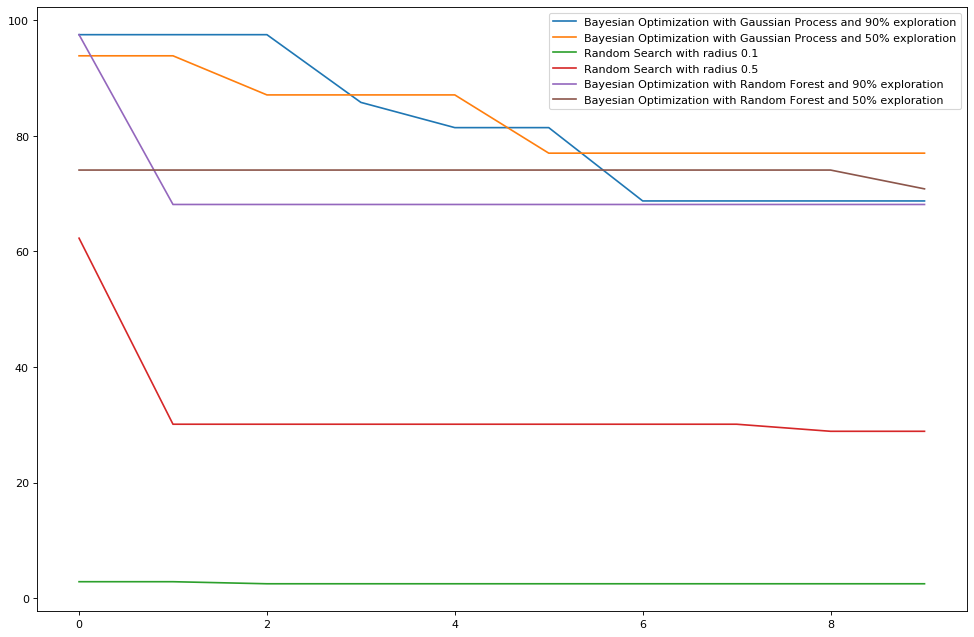

In [799]:
table,bestX,bestY = compare_methods(objective_function,10,5,100)

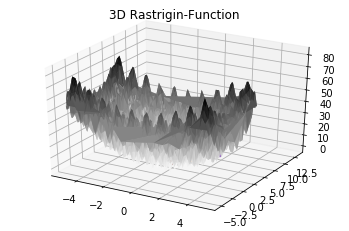

In [773]:
display_function_3D(5000,bestX,bestY)

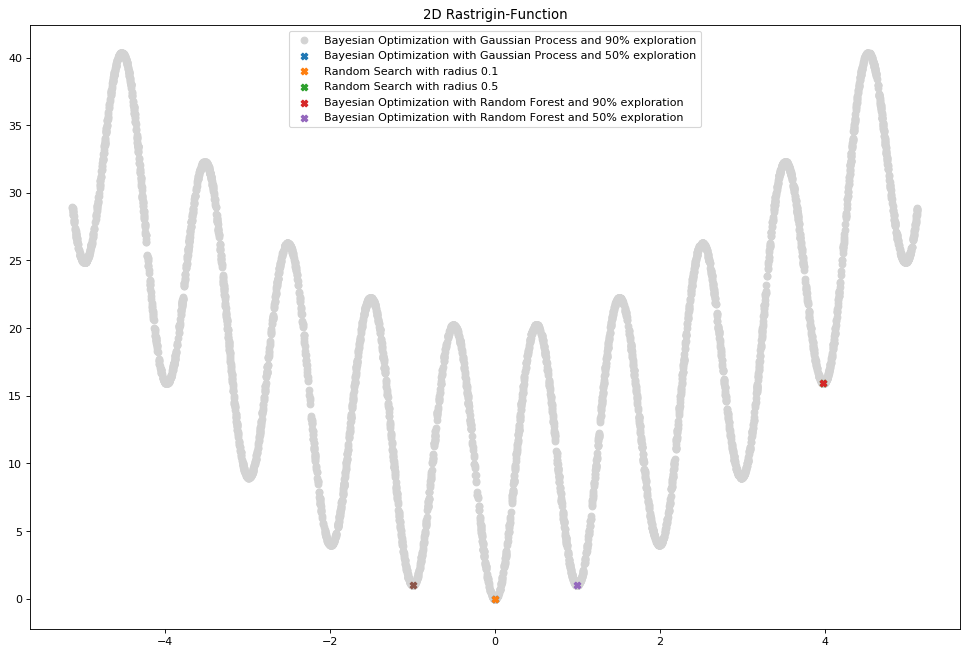

In [781]:
display_function_2D(5000,bestX,bestY)

In [782]:
table

,BO with GA and 90%,BO with GA and 50%,Random search with r=0.1,Random search with r=0.5,BO with RF and 90%,BO with RF and 50%
min Y,0.004902,0.000262,15.919318,15.919288,0.994962,0.995209
Norm of found point,0.004971,0.001149,3.980399,3.980258,0.994839,0.996082
